In [1]:
pwd()

"/Users/kyan/Projects/qgplsim"

# Start

In [132]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [139]:
# run this ceil for different data sets

α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [1.0, 0.5] # single index for z
β = [0.5, -1.0] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 300
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

0.7005735428202923 1.2747805796826956
6
  0.472785 seconds (1.76 M allocations: 2.534 GiB, 21.20% gc time)
Estimation of index coefs: 
̂α => [0.4451523677346016; 0.895454839453268]
̂γ => [0.9885655159321064, 0.610614321536273]
Estimation of linear coefs: 
̂θ => [1.988239650821304 -0.9884022612768639]
̂β => [-0.13749836394574622; -1.4953585297321799]


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

In [114]:
model1.index

Dict{Vector{Int64}, Vector{Int64}} with 6 entries:
  [0, 1] => [1, 6, 10, 14, 16, 20, 21, 22, 27, 28  …  246, 250, 253, 266, 287, …
  [1, 0] => [8, 15, 40, 41, 69, 85, 122, 126, 129, 130  …  218, 228, 229, 232, …
  [1, 2] => [4, 5, 23, 24, 35, 43, 51, 57, 59, 63  …  150, 159, 194, 227, 257, …
  [0, 2] => [2, 19, 42, 47, 53, 55, 58, 60, 66, 76  …  269, 273, 275, 278, 279,…
  [1, 1] => [3, 7, 11, 13, 18, 25, 26, 29, 30, 31  …  268, 270, 271, 274, 277, …
  [0, 0] => [9, 12, 17, 65, 73, 74, 77, 81, 96, 97  …  201, 205, 207, 214, 220,…

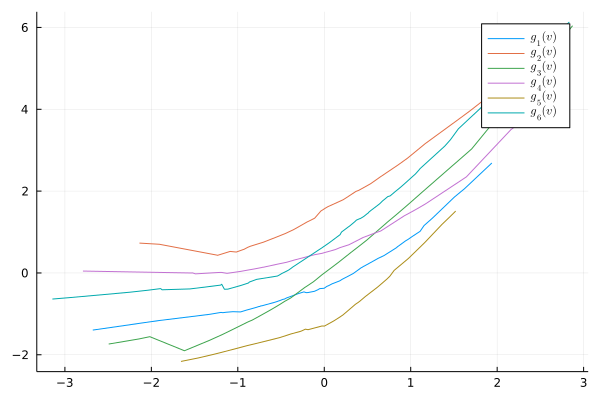

In [140]:
alphap = 1.0 * alpha1
v = X * alphap # g(Xα + Zγ) => univar func. g(v + zγ) after α was determined and  Z = z
categ, index = model1.categ, model1.index
g, dg = qgplsim.Gz_DGz(v, Z, y - X * transpose(theta), 0.5, -0.4) # g: g(v), dg: g'(v)
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]

    plot!(fig, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")

end
fig

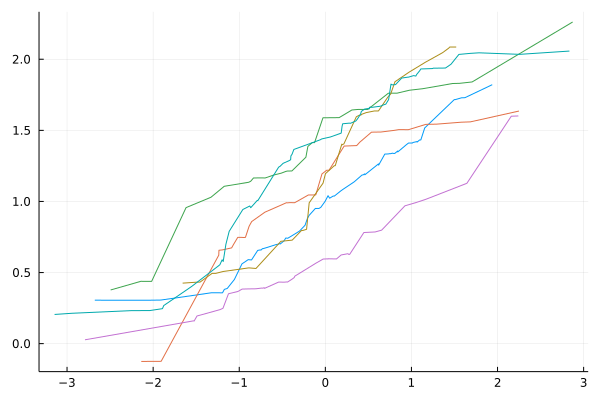

In [141]:
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_vm = vm[indm]
    plot!(fig, sorted_vm, sorted_dgm, label = false )#L"\nabla g_{%$m} (v)")

end
fig

# Monte Carlo Simulation

In [43]:
Threads.nthreads()

2

In [159]:
include("MonteCarloSIM.ji")

main (generic function with 4 methods)

In [168]:
α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [1.0, 0.5] # single index for z
β = [1.0, -2.0] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 600
fx = 2
dist = 1 # Cauchy
rep = 10 # MC rept. times

10

In [169]:
Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, fx, dist, rep)
mg = mean(Gamma, dims = 1)

-1.0885592355623501 1.7939126675513104
1.1162726349698293 1.8605018069431076
6
-1.5590478826928478 1.5864572940843193
-0.2581154771367667 1.6178051728893268
6
-1.4745360207039324 1.533658654313188
0.9488364591154547 2.182670147643593
6
-1.9751149302391222 1.7994032353654252
0.273903576445233 1.2263327531754595
6
-1.554936501298319 1.5048081816844454
0.8841734079761119 1.7521343790316792
6
-1.9151000713296153 1.9668221816854419
0.29811199857775494 1.711100258261688
6
-1.6610423561877719 1.581262761107729
0.32049996310571777 1.2354202323443269
6
-1.400365446928486 1.3575395031556123
0.3467721907548479 1.4844102977820195
6
-1.7593081536868085 1.7839244645484733
1.24031517137763 2.110272704383661
6
-1.926797144590807 1.4689733052701368
0.13445463209481584 1.8070998890153025
6


([0.5630167570449757 0.8264454799238476; 0.29546891404224757 0.9553523542833267; … ; 0.642945156305518 0.7659122181968853; 0.42355387483334067 0.9058709152598194], [0.41163744437992855 0.39883242537072844; 0.5662284461183186 0.23184024111328422; … ; 0.30776352696850695 0.38388187053029316; 0.7911828702651371 0.35202116693038343], [1.6886608926047695 -1.1504018142740848; 2.3026778578687948 -0.712166273525345; … ; 1.4851165210126083 -1.2466813442175766; 2.020284659485565 -0.9446151558426386], [0.915185002937959 -2.324306436569699; 1.023929732871531 -1.858054308705354; … ; 1.0674722660541174 -2.3594064585241696; 0.6539717806271259 -2.068602700553157])

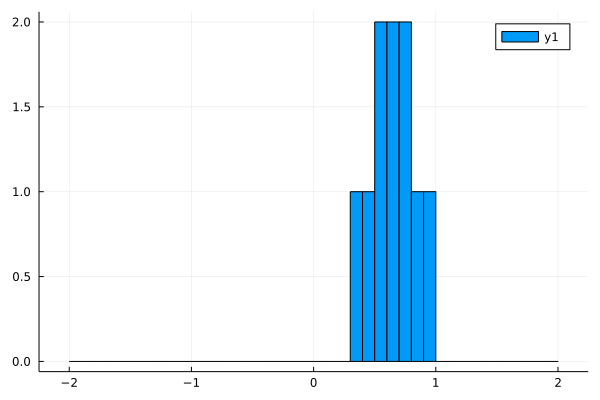

In [170]:
histogram(Gamma[:,1], bins = -2:0.1:2)

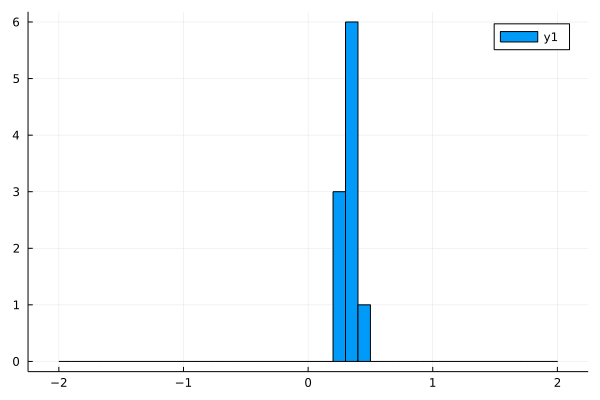

In [171]:
histogram(Gamma[:,2], bins = -2:0.1:2)

In [167]:
ma = mean(Alpha, dims = 1)

1×2 Matrix{Float64}:
 0.44855  0.887299

In [82]:
mb = mean(Beta, dims = 1)

1×2 Matrix{Float64}:
 1.12505  -1.99381

In [83]:
mt = mean(Theta, dims = 1)

1×2 Matrix{Float64}:
 1.96929  -0.969076

In [ ]:
(v1 * len1 + v2* len2) /(len - 1)

In [ ]:
var(abs.(Gamma), dims = 1)

In [ ]:
Ra= kmeans(transpose(Alpha), 2)
Ra.centers

In [ ]:
using DataFrames
df = DataFrame(α1 = Float64[], α2 = Float64[],
               var_α1 = Float64[], var_α2 = Float64[],    
               θ1 = Float64[], θ2 = Float64[],
               var_θ1 = Float64[], var_θ2 = Float64[], 
               β1 = Float64[], β2 = Float64[],
               var_β1 = Float64[], var_β2 = Float64[], 
               γ1 = Float64[], γ2 = Float64[],
               var_γ1 = Float64[], var_γ2 = Float64[])


In [ ]:
A = [:α1, :α2, :var_α1, :var_α2]
T = [:θ1, :θ2, :var_θ1, :var_θ2]
G = [:γ1, :γ2, :var_γ1, :var_γ2]
B = [:β1, :β2, :var_β1, :var_β2]

In [ ]:
@threads for γ in [[1.0, 0.5], [1.0, 0.001], [0.001, 1.0], [0.5, 1.0],[0.5, 0.5], [0.0001, 0.0001]]
    res, =  MonteCarlo(n, γ, θ, α, β, fx, dist, len, alpha_type)
    push!(df, res)
end